# TESS / CARMENES-GTO DATABASE LOADING AND INSPECTION

PoC - Light curve and radial velocity curve inspection and processing

## Modules and configuration

### Modules

In [515]:
# Modules import:
#from collections import OrderedDict

import numpy as np

from scipy import stats

from astropy.table import Table
from astropy.timeseries import TimeSeries
from astropy import units as u
from astropy.time import Time
from astropy.io import fits

import lightkurve as lk

import matplotlib.pyplot as plt

#import seaborn as sns
#sns.set_style("white", {'figure.figsize':(15,10)})
#sns.set_style("whitegrid")
#sns.set(rc={'figure.figsize':(15,8)})

### Configuration

In [516]:
# Configuration:
# Files:
LC_INPUT_FILE = "../data/CARMENES_GTO_TESS_lc/lightcurves/J00051+457/J00051+457_TESS_TIC439946126_S17.fits"
RV_INPUT_FILE = "../data/CARMENES_GTO_RVs/J00051+457.dat"

IMAGE_LC_OUT = "./img/ETL_20_01_Test_graph_TESS_Light_curve.png"
IMAGE_RV_OUT = "./img/ETL_20_02_Test_graph_Radial_velocity_curve.png"


## TESS light curve inspection

### TESS file initial inspection

In [517]:
tess_fits = Table.read(LC_INPUT_FILE, format='fits')
tess_fits[:5]

TIME,TIMECORR,CADENCENO,SAP_FLUX,SAP_FLUX_ERR,SAP_BKG,SAP_BKG_ERR,PDCSAP_FLUX,PDCSAP_FLUX_ERR,QUALITY,PSF_CENTR1,PSF_CENTR1_ERR,PSF_CENTR2,PSF_CENTR2_ERR,MOM_CENTR1,MOM_CENTR1_ERR,MOM_CENTR2,MOM_CENTR2_ERR,POS_CORR1,POS_CORR2
"BJD - 2457000, days",d,,e-/s,e-/s,e-/s,e-/s,e-/s,e-/s,,pix,pix,pix,pix,pix,pix,pix,pix,pixels,pixels
float64,float32,int32,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
1.7646832e+03,4.3311133e-03,386801,nan,nan,nan,nan,nan,nan,10101000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1.7646846e+03,4.3311333e-03,386802,nan,nan,nan,nan,nan,nan,100000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1.7646860e+03,4.3311534e-03,386803,nan,nan,nan,nan,nan,nan,100000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1.7646874e+03,4.3311729e-03,386804,nan,nan,nan,nan,nan,nan,100000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1.7646888e+03,4.3311929e-03,386805,8.5791609e+04,3.4615158e+01,2.7479731e+03,1.0910882e+01,8.9227219e+04,3.6116268e+01,0,nan,nan,nan,nan,1735.52932,3.3758229e-04,1882.66595,3.3336986e-04,9.4317487e-03,5.7261843e-02


In [518]:
tess_fits = fits.open(LC_INPUT_FILE, format='tess.fits')
print(tess_fits[0])
print(tess_fits[1])
print(tess_fits[2])

The first HDU header contains general information for the object (non-dependent of acquisition time), including the object identification (`TICID`). First HDU has no data.

In [519]:
tess_fits[0].header

SIMPLE  =                    T / conforms to FITS standards                     
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T / file contains extensions                       
NEXTEND =                    2 / number of standard extensions                  
EXTNAME = 'PRIMARY '           / name of extension                              
EXTVER  =                    1 / extension version number (not format version)  
SIMDATA =                    F / file is based on simulated data                
ORIGIN  = 'NASA/Ames'          / institution responsible for creating this file 
DATE    = '2020-04-11'         / file creation date.                            
TSTART  =    1764.688076527806 / observation start time in BTJD                 
TSTOP   =    1789.682359955120 / observation stop time in BTJD                  
DATE-OBS= '2019-10-08T04:29:

In [520]:
tess_fits[0].data

The second HDU contains the light curve data proper. The header contains mainly the column descriptions, the object identification (`TICID`) and the necessary data to know when the observation has been done, the total time spent on target, etc. The data is the light curve data with all the measured points.

According to the documentation, the column type should always be on `BJD - 2457000, days` units, but maybe better to individually double-check the `BJDREFI` and `BJDREFF` keywords, containing the time reference values.

In [521]:
tess_fits[1].header

XTENSION= 'BINTABLE'           / marks the beginning of a new HDU               
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  100 / length of first array dimension                
NAXIS2  =                18012 / length of second array dimension               
PCOUNT  =                    0 / group parameter count (not used)               
GCOUNT  =                    1 / group count (not used)                         
TFIELDS =                   20 / number of table fields                         
TTYPE1  = 'TIME    '           / column title: data time stamps                 
TFORM1  = 'D       '           / column format: 64-bit floating point           
TUNIT1  = 'BJD - 2457000, days' / column units: Barycenter corrected TESS Julian
TDISP1  = 'D14.7   '           / column display format                          
TTYPE2  = 'TIMECORR'        

Extracting time references and object ID from FITS header:

In [522]:
object_id = tess_fits[1].header['OBJECT']
bjdrefi = tess_fits[1].header['BJDREFI']
bjdreff = tess_fits[1].header['BJDREFF']
print("OBJECT = %s" %object_id)
print("BJDREFI = %d; BJDREFF = %f" %(bjdrefi,bjdreff))

OBJECT = TIC 439946126
BJDREFI = 2457000; BJDREFF = 0.000000


In [523]:
Table(tess_fits[1].data)

TIME,TIMECORR,CADENCENO,SAP_FLUX,SAP_FLUX_ERR,SAP_BKG,SAP_BKG_ERR,PDCSAP_FLUX,PDCSAP_FLUX_ERR,QUALITY,PSF_CENTR1,PSF_CENTR1_ERR,PSF_CENTR2,PSF_CENTR2_ERR,MOM_CENTR1,MOM_CENTR1_ERR,MOM_CENTR2,MOM_CENTR2_ERR,POS_CORR1,POS_CORR2
float64,float32,int32,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
1764.6832152336806,0.0043311133,386801,nan,nan,nan,nan,nan,nan,168,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1764.68460414199,0.0043311333,386802,nan,nan,nan,nan,nan,nan,32,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1764.6859930502992,0.0043311534,386803,nan,nan,nan,nan,nan,nan,32,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1764.6873819581429,0.004331173,386804,nan,nan,nan,nan,nan,nan,32,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1764.6887708664522,0.004331193,386805,85791.61,34.615158,2747.9731,10.910882,89227.22,36.11627,0,nan,nan,nan,nan,1735.5293227528875,0.00033758229,1882.6659477150336,0.00033336986,0.009431749,0.057261843
1764.6901597747617,0.004331213,386806,85780.03,34.611183,2745.1716,10.87844,89208.914,36.112118,0,nan,nan,nan,nan,1735.5293176414175,0.000338021,1882.6678256370465,0.0003332272,0.009436345,0.0592886
1764.691548683071,0.004331233,386807,85705.44,34.62287,2747.186,10.951503,89153.25,36.124313,0,nan,nan,nan,nan,1735.535090082888,0.000338426,1882.6683138167946,0.00033349846,0.014921385,0.059195742
1764.692937591381,0.004331253,386808,85627.46,34.613247,2746.4187,10.939362,89087.57,36.11427,0,nan,nan,nan,nan,1735.5261484955818,0.0003392005,1882.661519918828,0.00033427303,0.006309681,0.052819252
1764.6943264996912,0.004331273,386809,85788.51,34.634773,2756.085,10.93817,89209.93,36.136734,0,nan,nan,nan,nan,1735.529772883562,0.00033840782,1882.6658577586154,0.00033353933,0.01005409,0.058345847


In [524]:
tess_fits[1].data.dtype

dtype((numpy.record, [('TIME', '>f8'), ('TIMECORR', '>f4'), ('CADENCENO', '>i4'), ('SAP_FLUX', '>f4'), ('SAP_FLUX_ERR', '>f4'), ('SAP_BKG', '>f4'), ('SAP_BKG_ERR', '>f4'), ('PDCSAP_FLUX', '>f4'), ('PDCSAP_FLUX_ERR', '>f4'), ('QUALITY', '>i4'), ('PSF_CENTR1', '>f8'), ('PSF_CENTR1_ERR', '>f4'), ('PSF_CENTR2', '>f8'), ('PSF_CENTR2_ERR', '>f4'), ('MOM_CENTR1', '>f8'), ('MOM_CENTR1_ERR', '>f4'), ('MOM_CENTR2', '>f8'), ('MOM_CENTR2_ERR', '>f4'), ('POS_CORR1', '>f4'), ('POS_CORR2', '>f4')]))

The third HDU contains the aperture mask. Header also includes object identification (`TICID`), and data is the mask itself.

In [525]:
tess_fits[2].header

XTENSION= 'IMAGE   '           / marks the beginning of a new HDU               
BITPIX  =                   32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   11 / length of first array dimension                
NAXIS2  =                   13 / length of second array dimension               
PCOUNT  =                    0 / group parameter count (not used)               
GCOUNT  =                    1 / group count (not used)                         
INHERIT =                    T / inherit the primary header                     
EXTNAME = 'APERTURE'           / name of extension                              
EXTVER  =                    1 / extension version number (not format version)  
SIMDATA =                    F / file is based on simulated data                
TELESCOP= 'TESS    '           / telescope                                      
INSTRUME= 'TESS Photometer' 

In [526]:
tess_fits[2].data

array([[257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257],
       [257, 257, 261, 261, 261, 261, 261, 261, 261, 261, 257],
       [257, 261, 261, 261, 257, 257, 257, 257, 257, 261, 261],
       [257, 257, 261, 261, 257, 257, 257, 257, 257, 261, 261],
       [257, 257, 261, 257, 257, 267, 267, 257, 257, 257, 257],
       [257, 257, 257, 257, 267, 267, 267, 267, 257, 257, 257],
       [257, 257, 257, 267, 267, 267, 267, 267, 267, 257, 257],
       [257, 257, 257, 267, 267, 267, 267, 267, 267, 257, 257],
       [261, 261, 257, 257, 267, 267, 267, 267, 267, 257, 257],
       [257, 257, 257, 257, 257, 267, 267, 267, 257, 257, 261],
       [257, 257, 261, 261, 257, 257, 257, 257, 257, 257, 261],
       [257, 261, 257, 261, 261, 257, 257, 257, 261, 261, 261],
       [257, 257, 257, 261, 261, 261, 261, 261, 257, 261, 257]])

In [527]:
tess_fits.close()

### Load TESS light curve

In [528]:
tess_lk = lk.read(LC_INPUT_FILE)
tess_lk[:7]

time,flux,flux_err,timecorr,cadenceno,centroid_col,centroid_row,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,electron / s,electron / s,d,,pix,pix,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
object,float32,float32,float32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
1764.6887708664522,8.9227219e+04,3.6116268e+01,4.3311929e-03,386805,1735.52932,1882.66595,8.5791609e+04,3.4615158e+01,2.7479731e+03,1.0910882e+01,8.9227219e+04,3.6116268e+01,0,nan,nan,nan,nan,1735.52932,3.3758229e-04,1882.66595,3.3336986e-04,9.4317487e-03,5.7261843e-02
1764.6901597747617,8.9208914e+04,3.6112118e+01,4.3312130e-03,386806,1735.52932,1882.66783,8.5780031e+04,3.4611183e+01,2.7451716e+03,1.0878440e+01,8.9208914e+04,3.6112118e+01,0,nan,nan,nan,nan,1735.52932,3.3802100e-04,1882.66783,3.3322719e-04,9.4363447e-03,5.9288599e-02
1764.691548683071,8.9153250e+04,3.6124313e+01,4.3312330e-03,386807,1735.53509,1882.66831,8.5705438e+04,3.4622871e+01,2.7471860e+03,1.0951503e+01,8.9153250e+04,3.6124313e+01,0,nan,nan,nan,nan,1735.53509,3.3842601e-04,1882.66831,3.3349846e-04,1.4921385e-02,5.9195742e-02
1764.692937591381,8.9087570e+04,3.6114269e+01,4.3312530e-03,386808,1735.52615,1882.66152,8.5627461e+04,3.4613247e+01,2.7464187e+03,1.0939362e+01,8.9087570e+04,3.6114269e+01,0,nan,nan,nan,nan,1735.52615,3.3920049e-04,1882.66152,3.3427303e-04,6.3096811e-03,5.2819252e-02
1764.6943264996912,8.9209930e+04,3.6136734e+01,4.3312730e-03,386809,1735.52977,1882.66586,8.5788508e+04,3.4634773e+01,2.7560850e+03,1.0938170e+01,8.9209930e+04,3.6136734e+01,0,nan,nan,nan,nan,1735.52977,3.3840782e-04,1882.66586,3.3353933e-04,1.0054090e-02,5.8345847e-02
1764.6957154075349,8.9232195e+04,3.6120758e+01,4.3312926e-03,386810,1735.53313,1882.66787,8.5803258e+04,3.4619461e+01,2.7502805e+03,1.0927849e+01,8.9232195e+04,3.6120758e+01,0,nan,nan,nan,nan,1735.53313,3.3751249e-04,1882.66787,3.3296234e-04,1.3339720e-02,5.8859117e-02
1764.6971043158442,8.9126555e+04,3.6123978e+01,4.3313126e-03,386811,1735.53014,1882.66736,8.5712211e+04,3.4622551e+01,2.7457996e+03,1.0923735e+01,8.9126555e+04,3.6123978e+01,0,nan,nan,nan,nan,1735.53014,3.3785202e-04,1882.66736,3.3398034e-04,1.0210144e-02,5.8872852e-02


### Change time to `BJD` in TESS light curve

In [529]:
bjdrefi

2457000

In [530]:
bjdreff

0.0

In [531]:
tess_lk['time'] = tess_lk['time'] + bjdrefi + bjdreff
tess_lk[:7]

time,flux,flux_err,timecorr,cadenceno,centroid_col,centroid_row,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,electron / s,electron / s,d,,pix,pix,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
object,float32,float32,float32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
2458764.6887708665,8.9227219e+04,3.6116268e+01,4.3311929e-03,386805,1735.52932,1882.66595,8.5791609e+04,3.4615158e+01,2.7479731e+03,1.0910882e+01,8.9227219e+04,3.6116268e+01,0,nan,nan,nan,nan,1735.52932,3.3758229e-04,1882.66595,3.3336986e-04,9.4317487e-03,5.7261843e-02
2458764.690159775,8.9208914e+04,3.6112118e+01,4.3312130e-03,386806,1735.52932,1882.66783,8.5780031e+04,3.4611183e+01,2.7451716e+03,1.0878440e+01,8.9208914e+04,3.6112118e+01,0,nan,nan,nan,nan,1735.52932,3.3802100e-04,1882.66783,3.3322719e-04,9.4363447e-03,5.9288599e-02
2458764.691548683,8.9153250e+04,3.6124313e+01,4.3312330e-03,386807,1735.53509,1882.66831,8.5705438e+04,3.4622871e+01,2.7471860e+03,1.0951503e+01,8.9153250e+04,3.6124313e+01,0,nan,nan,nan,nan,1735.53509,3.3842601e-04,1882.66831,3.3349846e-04,1.4921385e-02,5.9195742e-02
2458764.6929375916,8.9087570e+04,3.6114269e+01,4.3312530e-03,386808,1735.52615,1882.66152,8.5627461e+04,3.4613247e+01,2.7464187e+03,1.0939362e+01,8.9087570e+04,3.6114269e+01,0,nan,nan,nan,nan,1735.52615,3.3920049e-04,1882.66152,3.3427303e-04,6.3096811e-03,5.2819252e-02
2458764.6943264995,8.9209930e+04,3.6136734e+01,4.3312730e-03,386809,1735.52977,1882.66586,8.5788508e+04,3.4634773e+01,2.7560850e+03,1.0938170e+01,8.9209930e+04,3.6136734e+01,0,nan,nan,nan,nan,1735.52977,3.3840782e-04,1882.66586,3.3353933e-04,1.0054090e-02,5.8345847e-02
2458764.6957154074,8.9232195e+04,3.6120758e+01,4.3312926e-03,386810,1735.53313,1882.66787,8.5803258e+04,3.4619461e+01,2.7502805e+03,1.0927849e+01,8.9232195e+04,3.6120758e+01,0,nan,nan,nan,nan,1735.53313,3.3751249e-04,1882.66787,3.3296234e-04,1.3339720e-02,5.8859117e-02
2458764.6971043157,8.9126555e+04,3.6123978e+01,4.3313126e-03,386811,1735.53014,1882.66736,8.5712211e+04,3.4622551e+01,2.7457996e+03,1.0923735e+01,8.9126555e+04,3.6123978e+01,0,nan,nan,nan,nan,1735.53014,3.3785202e-04,1882.66736,3.3398034e-04,1.0210144e-02,5.8872852e-02


In [532]:
tess_lk.columns

<TableColumns names=('time','flux','flux_err','timecorr','cadenceno','centroid_col','centroid_row','sap_flux','sap_flux_err','sap_bkg','sap_bkg_err','pdcsap_flux','pdcsap_flux_err','quality','psf_centr1','psf_centr1_err','psf_centr2','psf_centr2_err','mom_centr1','mom_centr1_err','mom_centr2','mom_centr2_err','pos_corr1','pos_corr2')>

In [533]:
tess_lk['time'].format

'btjd'

No need to change the format for the time column at the moment (which is related to time as measured by TESS). Only if we had TESS and CARMENES curves for the same object, at the same timewe would need to convert.

### Analize the cadence of TESS light curve

In [534]:
tess_td = tess_lk['time'][1:] - tess_lk['time'][:-1]
tess_td

<TimeDelta object: scale='tdb' format='jd' value=[0.00138891 0.00138891 0.00138891 ... 0.00138887 0.00138887 0.00138887]>

In [535]:
print("[%s ... %s]" %(sorted(tess_td.value)[:5], sorted(tess_td.value)[-5:]))

[[0.0013888608118577395, 0.0013888608118577395, 0.0013888608118577395, 0.0013888608118577395, 0.0013888608118577395] ... [0.011111147267001797, 0.016666406582771742, 0.020832996935951087, 0.024999565402822554, 1.4444444835710328]]


In seconds:

In [536]:
tess_td.format = 'sec'
tess_td

<TimeDelta object: scale='tdb' format='sec' value=[120.00167794 120.00167792 120.00167798 ... 119.99829842 119.9982984
 119.99829834]>

In [537]:
tess_np= np.array(tess_td.value)
tess_np

array([120.00167794, 120.00167792, 120.00167798, ..., 119.99829842,
       119.9982984 , 119.99829834])

In [538]:
tess_hist = np.histogram(tess_np)
tess_hist

(array([16661,     0,     0,     0,     0,     0,     0,     0,     0,
            1], dtype=int64),
 array([1.19997574e+02, 1.25879982e+04, 2.50559987e+04, 3.75239993e+04,
        4.99919999e+04, 6.24600005e+04, 7.49280011e+04, 8.73960016e+04,
        9.98640022e+04, 1.12332003e+05, 1.24800003e+05]))

In [539]:
stats.mode(tess_np)

ModeResult(mode=array([119.99962603]), count=array([375]))

In [540]:
np.median(tess_np)

119.99946510186419

In [541]:
np.mean(tess_np)

129.68587731080237

### Converting flux to magnitudes in TESS light curve

For the flux nominal value, we use the plain approximation:

$$mag=-2.5log(flux)$$

For the error (standard deviation) in _flux_, the following expression applies. This expression is derived through a Taylor series expansion of the errors in a random variable (_magnitude_) when this quantity is expressed as a function of another random variable (_flux_). A gaussian distribution is assumed for the _flux_ random variable.

$$\sigma_{mag}=2.5\frac{\sigma_{flux}}{flux}$$


In [542]:
tess_lk['MAG_pdcsap'] = -2.5 * np.log10(tess_lk['pdcsap_flux'] / (1 * u.electron / (1.0 * u.second)))
tess_lk['MAG_pdcsap_err'] = 2.5 * tess_lk['pdcsap_flux_err'] / tess_lk['pdcsap_flux']
tess_lk[:7]

time,flux,flux_err,timecorr,cadenceno,centroid_col,centroid_row,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2,MAG_pdcsap,MAG_pdcsap_err
,electron / s,electron / s,d,,pix,pix,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix,,
object,float32,float32,float32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32,float32,float32
2458764.6887708665,8.9227219e+04,3.6116268e+01,4.3311929e-03,386805,1735.52932,1882.66595,8.5791609e+04,3.4615158e+01,2.7479731e+03,1.0910882e+01,8.9227219e+04,3.6116268e+01,0,nan,nan,nan,nan,1735.52932,3.3758229e-04,1882.66595,3.3336986e-04,9.4317487e-03,5.7261843e-02,-1.2376243e+01,1.0119185e-03
2458764.690159775,8.9208914e+04,3.6112118e+01,4.3312130e-03,386806,1735.52932,1882.66783,8.5780031e+04,3.4611183e+01,2.7451716e+03,1.0878440e+01,8.9208914e+04,3.6112118e+01,0,nan,nan,nan,nan,1735.52932,3.3802100e-04,1882.66783,3.3322719e-04,9.4363447e-03,5.9288599e-02,-1.2376021e+01,1.0120098e-03
2458764.691548683,8.9153250e+04,3.6124313e+01,4.3312330e-03,386807,1735.53509,1882.66831,8.5705438e+04,3.4622871e+01,2.7471860e+03,1.0951503e+01,8.9153250e+04,3.6124313e+01,0,nan,nan,nan,nan,1735.53509,3.3842601e-04,1882.66831,3.3349846e-04,1.4921385e-02,5.9195742e-02,-1.2375343e+01,1.0129836e-03
2458764.6929375916,8.9087570e+04,3.6114269e+01,4.3312530e-03,386808,1735.52615,1882.66152,8.5627461e+04,3.4613247e+01,2.7464187e+03,1.0939362e+01,8.9087570e+04,3.6114269e+01,0,nan,nan,nan,nan,1735.52615,3.3920049e-04,1882.66152,3.3427303e-04,6.3096811e-03,5.2819252e-02,-1.2374543e+01,1.0134486e-03
2458764.6943264995,8.9209930e+04,3.6136734e+01,4.3312730e-03,386809,1735.52977,1882.66586,8.5788508e+04,3.4634773e+01,2.7560850e+03,1.0938170e+01,8.9209930e+04,3.6136734e+01,0,nan,nan,nan,nan,1735.52977,3.3840782e-04,1882.66586,3.3353933e-04,1.0054090e-02,5.8345847e-02,-1.2376033e+01,1.0126882e-03
2458764.6957154074,8.9232195e+04,3.6120758e+01,4.3312926e-03,386810,1735.53313,1882.66787,8.5803258e+04,3.4619461e+01,2.7502805e+03,1.0927849e+01,8.9232195e+04,3.6120758e+01,0,nan,nan,nan,nan,1735.53313,3.3751249e-04,1882.66787,3.3296234e-04,1.3339720e-02,5.8859117e-02,-1.2376304e+01,1.0119878e-03
2458764.6971043157,8.9126555e+04,3.6123978e+01,4.3313126e-03,386811,1735.53014,1882.66736,8.5712211e+04,3.4622551e+01,2.7457996e+03,1.0923735e+01,8.9126555e+04,3.6123978e+01,0,nan,nan,nan,nan,1735.53014,3.3785202e-04,1882.66736,3.3398034e-04,1.0210144e-02,5.8872852e-02,-1.2375017e+01,1.0132777e-03


Now, we must tell the TESS light curve that the magnitudes are the 'flux'.

In [543]:
tess_lk.meta

{'INHERIT': True,
 'EXTNAME': 'PRIMARY',
 'EXTVER': 1,
 'SIMDATA': False,
 'TELESCOP': 'TESS',
 'INSTRUME': 'TESS Photometer',
 'OBJECT': 'TIC 439946126',
 'TICID': 439946126,
 'RADESYS': 'ICRS',
 'RA_OBJ': 1.29537156257181,
 'DEC_OBJ': 45.7865665447841,
 'EQUINOX': 2000.0,
 'EXPOSURE': 19.795472657766,
 'TIMEREF': 'SOLARSYSTEM',
 'TASSIGN': 'SPACECRAFT',
 'TIMESYS': 'TDB',
 'BJDREFI': 2457000,
 'BJDREFF': 0.0,
 'TIMEUNIT': 'd',
 'TELAPSE': 24.994283658796,
 'LIVETIME': 19.79547265776635,
 'TSTART': 1764.688076527806,
 'TSTOP': 1789.68235995512,
 'DATE-OBS': '2019-10-08T04:29:40.628',
 'DATE-END': '2019-11-02T04:21:26.716',
 'DEADC': 0.792,
 'TIMEPIXR': 0.5,
 'TIERRELA': 1.16e-05,
 'INT_TIME': 1.98,
 'READTIME': 0.02,
 'FRAMETIM': 2.0,
 'NUM_FRM': 60,
 'TIMEDEL': 0.001388888888888889,
 'BACKAPP': True,
 'DEADAPP': True,
 'VIGNAPP': True,
 'GAINA': 5.28000020980835,
 'GAINB': 5.260000228881836,
 'GAINC': 5.25,
 'GAIND': 5.210000038146973,
 'READNOIA': 9.873600006103516,
 'READNOIB': 7.6

We must tell the class to select magnitudes as the "flux".

In [544]:
tess_lk_2 = tess_lk.select_flux(flux_column='MAG_pdcsap', flux_err_column='MAG_pdcsap_err')
tess_lk_2.meta['FLUX_ORIGIN'] = 'MAG_pdcsap'
tess_lk_2[:7]

time,flux,flux_err,timecorr,cadenceno,centroid_col,centroid_row,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2,MAG_pdcsap,MAG_pdcsap_err
,,,d,,pix,pix,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix,,
object,float32,float32,float32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32,float32,float32
2458764.6887708665,-1.2376243e+01,1.0119185e-03,4.3311929e-03,386805,1735.52932,1882.66595,8.5791609e+04,3.4615158e+01,2.7479731e+03,1.0910882e+01,8.9227219e+04,3.6116268e+01,0,nan,nan,nan,nan,1735.52932,3.3758229e-04,1882.66595,3.3336986e-04,9.4317487e-03,5.7261843e-02,-1.2376243e+01,1.0119185e-03
2458764.690159775,-1.2376021e+01,1.0120098e-03,4.3312130e-03,386806,1735.52932,1882.66783,8.5780031e+04,3.4611183e+01,2.7451716e+03,1.0878440e+01,8.9208914e+04,3.6112118e+01,0,nan,nan,nan,nan,1735.52932,3.3802100e-04,1882.66783,3.3322719e-04,9.4363447e-03,5.9288599e-02,-1.2376021e+01,1.0120098e-03
2458764.691548683,-1.2375343e+01,1.0129836e-03,4.3312330e-03,386807,1735.53509,1882.66831,8.5705438e+04,3.4622871e+01,2.7471860e+03,1.0951503e+01,8.9153250e+04,3.6124313e+01,0,nan,nan,nan,nan,1735.53509,3.3842601e-04,1882.66831,3.3349846e-04,1.4921385e-02,5.9195742e-02,-1.2375343e+01,1.0129836e-03
2458764.6929375916,-1.2374543e+01,1.0134486e-03,4.3312530e-03,386808,1735.52615,1882.66152,8.5627461e+04,3.4613247e+01,2.7464187e+03,1.0939362e+01,8.9087570e+04,3.6114269e+01,0,nan,nan,nan,nan,1735.52615,3.3920049e-04,1882.66152,3.3427303e-04,6.3096811e-03,5.2819252e-02,-1.2374543e+01,1.0134486e-03
2458764.6943264995,-1.2376033e+01,1.0126882e-03,4.3312730e-03,386809,1735.52977,1882.66586,8.5788508e+04,3.4634773e+01,2.7560850e+03,1.0938170e+01,8.9209930e+04,3.6136734e+01,0,nan,nan,nan,nan,1735.52977,3.3840782e-04,1882.66586,3.3353933e-04,1.0054090e-02,5.8345847e-02,-1.2376033e+01,1.0126882e-03
2458764.6957154074,-1.2376304e+01,1.0119878e-03,4.3312926e-03,386810,1735.53313,1882.66787,8.5803258e+04,3.4619461e+01,2.7502805e+03,1.0927849e+01,8.9232195e+04,3.6120758e+01,0,nan,nan,nan,nan,1735.53313,3.3751249e-04,1882.66787,3.3296234e-04,1.3339720e-02,5.8859117e-02,-1.2376304e+01,1.0119878e-03
2458764.6971043157,-1.2375017e+01,1.0132777e-03,4.3313126e-03,386811,1735.53014,1882.66736,8.5712211e+04,3.4622551e+01,2.7457996e+03,1.0923735e+01,8.9126555e+04,3.6123978e+01,0,nan,nan,nan,nan,1735.53014,3.3785202e-04,1882.66736,3.3398034e-04,1.0210144e-02,5.8872852e-02,-1.2375017e+01,1.0132777e-03


### Plot and store the TESS light curve

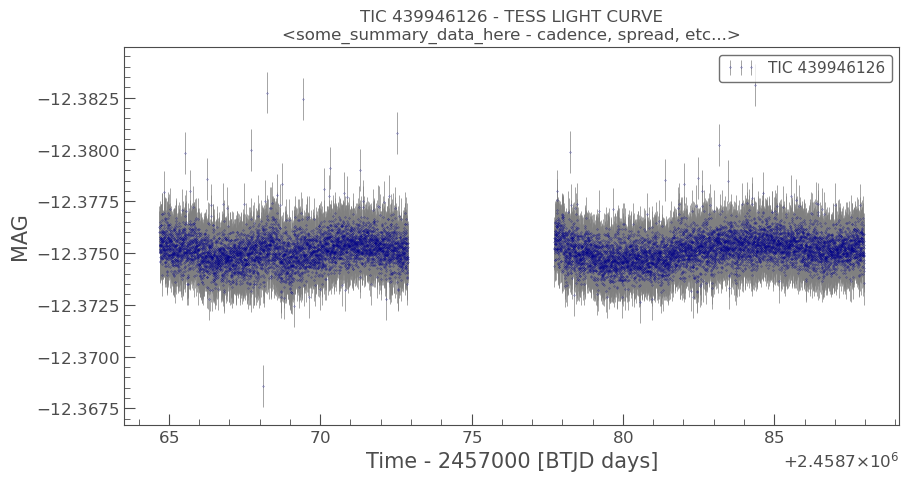

In [545]:
ax = tess_lk_2.errorbar(marker='o', ms=0.2, color='darkblue', ecolor='gray')
ax.figure.set_size_inches(10,5)
ax.invert_yaxis()
ax.set_ylabel("MAG")
ax.set_title("%s - TESS LIGHT CURVE\n"
             "<some_summary_data_here - cadence, spread, etc...>" %object_id)
plt.savefig(IMAGE_LC_OUT)
plt.show();

### Calculate and store the periodogram of TESS light curve

In [1]:
def tess_get_info():
    '''Gets information of the TESS object and light curve from FITS header'''
    return None

In [2]:
def tess_adjust_time():
    '''Adjust TESS light curve time column to absolute BJD values'''
    return None

In [3]:
def tess_cadence():
    '''Infers the cadence of the light curve from the data'''
    return None

In [ ]:
def tess_periodogram():
    '''Calculates the periodogram for a TESS light curve'''
    return None

In [4]:
def tess_plot_save():
    '''Plots and/or save the TESS light curve with additional info'''
    return None

In [ ]:
def tess_process(filename):
    '''Processes a TESS light curve file'''
    
    

## CARMENES radial velocity curve inspection

These are very simple files: just plain text, three columns, no header. First column is time ($BJD$), second column is radial velocity ($ms^{-1}$), third column is radial velocity error ($ms^{-1}$). \<TBC\>

### Load radial velocity curve

In [546]:
rv = Table.read(RV_INPUT_FILE, format='ascii',
                names = ['time', 'RV', 'eRV'], units=[u.d, u.meter / u.second, u.meter / u.second])
rv[:10]

time,RV,eRV
d,m / s,m / s
float64,float64,float64
2457400.28515,22.3283340297,1.4018315418
2457421.26037,23.7637567866,1.48502877524
2457588.68128,31.8136290804,1.45941122559
2457605.66563,27.1810782306,1.39936379403
2457609.66891,30.8604332996,0.853789077456
2457610.67461,26.5174127112,2.42228045236
2457611.62235,33.7972831499,2.1215444299
2457620.43878,18.2264721274,2.49049263079


### Convert to `LightCurve` object

In [547]:
rv_lk = lk.LightCurve(time=rv['time'], flux=rv['RV'], flux_err=rv['eRV'])
rv_lk[:10]

time,flux,flux_err
,m / s,m / s
object,float64,float64
2457400.28515,22.3283340297,1.4018315418
2457421.26037,23.7637567866,1.48502877524
2457588.68128,31.8136290804,1.45941122559
2457605.66563,27.1810782306,1.39936379403
2457609.66891,30.8604332996,0.853789077456
2457610.67461,26.5174127112,2.42228045236
2457611.62235,33.7972831499,2.1215444299
2457620.43878,18.2264721274,2.49049263079


### Analize cadence of radial velocity curve

Intervals between adjacent points:

In [548]:
td_rv = rv_lk['time'][1:] - rv_lk['time'][:-1]
td_rv

<TimeDelta object: scale='tdb' format='jd' value=[ 20.97522 167.42091  16.98435   4.00328   1.0057    0.94774   8.81643
  13.14844   2.98502   9.01831   1.90263   1.15332   0.96316   3.91321
   4.00658  20.88559   7.06932   2.9823    6.93578   9.94764   6.0013
 199.23861  26.03098   0.99561   1.88958   7.11871   4.86134   2.97754
   2.03042   4.12329   0.97153   1.02686   1.9748    1.02175   3.0242
   2.03349   0.95415   5.83405  10.12784   9.94196   3.02198   1.00256
   1.04182   2.93061   2.04231   1.95442  20.93976  27.96075   1.01493
   0.95115  33.11325]>

In [549]:
carmenes_np= np.array(td_rv.value)
carmenes_np

array([ 20.97522, 167.42091,  16.98435,   4.00328,   1.0057 ,   0.94774,
         8.81643,  13.14844,   2.98502,   9.01831,   1.90263,   1.15332,
         0.96316,   3.91321,   4.00658,  20.88559,   7.06932,   2.9823 ,
         6.93578,   9.94764,   6.0013 , 199.23861,  26.03098,   0.99561,
         1.88958,   7.11871,   4.86134,   2.97754,   2.03042,   4.12329,
         0.97153,   1.02686,   1.9748 ,   1.02175,   3.0242 ,   2.03349,
         0.95415,   5.83405,  10.12784,   9.94196,   3.02198,   1.00256,
         1.04182,   2.93061,   2.04231,   1.95442,  20.93976,  27.96075,
         1.01493,   0.95115,  33.11325])

In [550]:
carmenes_hist = np.histogram(carmenes_np)
carmenes_hist

(array([43,  6,  0,  0,  0,  0,  0,  0,  1,  1], dtype=int64),
 array([  0.94774 ,  20.776827,  40.605914,  60.435001,  80.264088,
        100.093175, 119.922262, 139.751349, 159.580436, 179.409523,
        199.23861 ]))

In [551]:
stats.mode(carmenes_np)

ModeResult(mode=array([0.94774]), count=array([1]))

In [552]:
np.median(carmenes_np)

3.02419999986887

In [553]:
np.mean(carmenes_np)

13.592479999998913

In [554]:
print("[%s ... %s]" %(sorted(carmenes_np)[:5], sorted(carmenes_np)[-5:]))

[[0.9477399997413158, 0.9511500000953674, 0.9541499996557832, 0.9631600002758205, 0.9715300002135336] ... [26.030980000272393, 27.96075000008568, 33.11324999993667, 167.42091000033543, 199.23860999988392]]


In [555]:
type(td_rv)

astropy.time.core.TimeDelta

In [556]:
tess_lk.meta

{'INHERIT': True,
 'EXTNAME': 'PRIMARY',
 'EXTVER': 1,
 'SIMDATA': False,
 'TELESCOP': 'TESS',
 'INSTRUME': 'TESS Photometer',
 'OBJECT': 'TIC 439946126',
 'TICID': 439946126,
 'RADESYS': 'ICRS',
 'RA_OBJ': 1.29537156257181,
 'DEC_OBJ': 45.7865665447841,
 'EQUINOX': 2000.0,
 'EXPOSURE': 19.795472657766,
 'TIMEREF': 'SOLARSYSTEM',
 'TASSIGN': 'SPACECRAFT',
 'TIMESYS': 'TDB',
 'BJDREFI': 2457000,
 'BJDREFF': 0.0,
 'TIMEUNIT': 'd',
 'TELAPSE': 24.994283658796,
 'LIVETIME': 19.79547265776635,
 'TSTART': 1764.688076527806,
 'TSTOP': 1789.68235995512,
 'DATE-OBS': '2019-10-08T04:29:40.628',
 'DATE-END': '2019-11-02T04:21:26.716',
 'DEADC': 0.792,
 'TIMEPIXR': 0.5,
 'TIERRELA': 1.16e-05,
 'INT_TIME': 1.98,
 'READTIME': 0.02,
 'FRAMETIM': 2.0,
 'NUM_FRM': 60,
 'TIMEDEL': 0.001388888888888889,
 'BACKAPP': True,
 'DEADAPP': True,
 'VIGNAPP': True,
 'GAINA': 5.28000020980835,
 'GAINB': 5.260000228881836,
 'GAINC': 5.25,
 'GAIND': 5.210000038146973,
 'READNOIA': 9.873600006103516,
 'READNOIB': 7.6

### Set key fields in metadata for the radial velocity curve

In [557]:
rv_lk.meta

OrderedDict()

In [558]:
rv_lk.meta = dict({
    'OBJECT':"<put_name_here>",
    'BJDREFI': 2457000,
    'BJDREFF': 0.0,
    'TIMEUNIT':'d'
})
rv_lk.meta

{'OBJECT': '<put_name_here>',
 'BJDREFI': 2457000,
 'BJDREFF': 0.0,
 'TIMEUNIT': 'd'}

In [559]:
rv_lk.meta

{'OBJECT': '<put_name_here>',
 'BJDREFI': 2457000,
 'BJDREFF': 0.0,
 'TIMEUNIT': 'd'}

### Calculate periodogram

### Plot and store the radial velocity curve

In [560]:
print(list(rv_lk.columns))

['time', 'flux', 'flux_err']


In [561]:
rv_lk.meta

{'OBJECT': '<put_name_here>',
 'BJDREFI': 2457000,
 'BJDREFF': 0.0,
 'TIMEUNIT': 'd'}

In [562]:
rv_lk[:7]

time,flux,flux_err
,m / s,m / s
object,float64,float64
2457400.28515,22.3283340297,1.4018315418
2457421.26037,23.7637567866,1.48502877524
2457588.68128,31.8136290804,1.45941122559
2457605.66563,27.1810782306,1.39936379403
2457609.66891,30.8604332996,0.853789077456
2457610.67461,26.5174127112,2.42228045236
2457611.62235,33.7972831499,2.1215444299


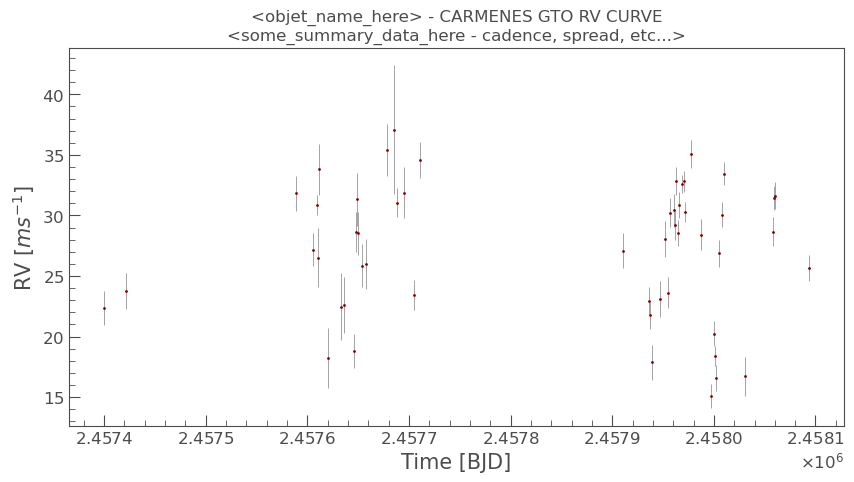

In [563]:
ax = rv_lk.errorbar(marker='o', ms=1.0, color='darkred', ecolor='gray')
ax.figure.set_size_inches(10,5)
ax.set_xlabel("Time [BJD]")
ax.set_ylabel("RV [$ms^{-1}$]")
ax.set_title("<objet_name_here> - CARMENES GTO RV CURVE\n"
             "<some_summary_data_here - cadence, spread, etc...>")
plt.savefig(IMAGE_RV_OUT)
plt.show();

## Summary --- pending ---

**OBSERVATIONS AND CONCLUSIONS:** -----------------
- From the GTO sample, we have 224 stars in the _"He3-burning"_ instability band ($\approx62\%$ of the sample).
- If we take into account the error margins in the `logg` and `Teff_K` variables, the number increases slightly to 259 stars ($\approx71\%$ of the sample))
- The percentages in the _"He3-burning"_ instability bands for the sample of non-GTO stars are $\approx41\%$ (nominal) and $\approx49\%$ (ranged).
- Hence, a greater fraction of GTO stars are prone to belong to the _"He3-burning"_ instability band.
- No star in the total _CARMENES_ sample is located in the _"D-burning"_ stability band.
- Notice that some stars in the database have no `Teff_K` or `logg` values, so their belonging to instability bands is unknown:
  - 4 GTO stars have no `logg`value.
  - 555 non-GTO stars have no `Teff_K`value; 556 non-GTO stars have no `logg` value.